In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class EnergyBasedModel(nn.Module):
    def __init__(self, input_channels, num_classes, beta):
        super(EnergyBasedModel, self).__init__()
        self.segmentation_model = SegmentationModel(input_channels, num_classes)
        self.beta = beta  # Regularization parameter

    def forward(self, image, segmentation_mask=None):
        # Calculate the energy function
        segmentation_logits = self.segmentation_model(image)
        
        # Compute data term (e.g., reconstruction loss)
        reconstruction_loss = torch.mean(torch.square(image - segmentation_logits))

        # Compute regularization term (e.g., L2 regularization)
        regularization_term = 0.0
        for param in self.parameters():
            regularization_term += torch.norm(param, 2)
        
        # Total energy is the sum of reconstruction loss and regularization term
        energy = reconstruction_loss + self.beta * regularization_term
        
        return energy, segmentation_logits


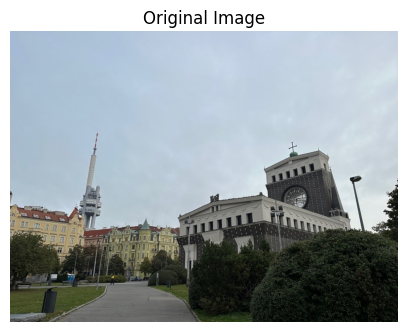

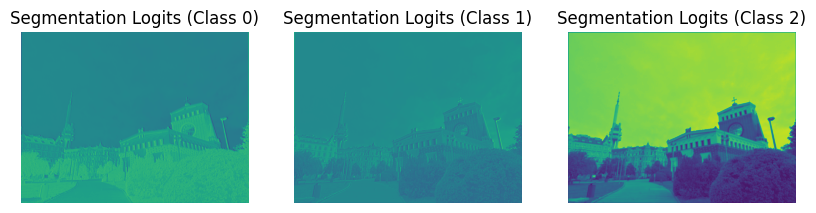

Energy: 0.47555240988731384


In [31]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Load the real image
image_path = "./data/train/church/images/00001.png"
image = Image.open(image_path)

# Convert the image to RGB if it has a single channel
if image.mode != 'RGB':
    image = image.convert('RGB')

transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Example usage
input_channels = 3  # Assuming RGB images
num_classes = 3  # Example: number of channels in segmentation mask
beta = 0.01  # Regularization parameter
model = EnergyBasedModel(input_channels, num_classes, beta)

# Plot the original image
plt.figure(figsize=(5, 5))
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.show()

# Forward pass to calculate the energy and segmentation logits
energy, segmentation_logits = model(image_tensor)

# Plot the segmentation logits
plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    plt.title("Segmentation Logits (Class {})".format(i))
    plt.imshow(segmentation_logits[0, i].detach().numpy(), cmap='viridis')
    plt.axis('off')
plt.show()

print("Energy:", energy.item())